# Visualizing Major Earthquake Events in R

Here we will use publicly-available data to examine major earthquakes taking place between 1970 and 2014 in the United States and around the world. We will first be doing simple visualizations of the data and move on to aggregating earthquake numbers by state and visualizing that. 

## Load in the Required Packages
This tutorial only requires the packages used below

In [7]:
library(tidyverse) #For data wrangling
library(sp) #For Spatial data
library(rgdal) #Ditto
library(tmap) #For spatial data visualization

## Downloading the Data
Here we will download and unzip the earthquake data and a shapefile of the United States

In [ ]:
eq.file.path <- "https://data.humdata.org/dataset/4881d82b-ba63-4515-b748-c364f3d05b42/resource/10ac8776-5141-494b-b3cd-bf7764b2f964/download/earthquakes1970-2014.csv"
eq.file.dest <- "earthquakes.csv"
download.file(eq.file.path, eq.file.dest)

us.file.path <- "https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5"
us.file.dest <- "states_21basic.zip"
download.file(us.file.path, us.file.dest)
unzip("states_21basic.zip")

## Load in the Data
Now that the data is downloaded, we will load it into our R environment. We can already visualize our USA shapefile and examine the data contained in the earthquake csv. 

OGR data source with driver: ESRI Shapefile 
Source: "/Users/isaackamber/Desktop/School Stuff/GIS 3/states_21basic", layer: "states"
with 51 features
It has 5 fields
Observations: 5,304
Variables: 12
$ DateTime   <fct> 1970/01/04 17:00:40.20, 1970/01/06 05:35:51.80, 1970/01/08…
$ Latitude   <dbl> 24.1390, -9.6280, -34.7410, 6.8250, 60.2800, -25.8000, 42.…
$ Longitude  <dbl> 102.5030, 151.4580, 178.5680, 126.7370, -152.6600, -177.34…
$ Depth      <dbl> 31, 8, 179, 73, 85, 80, 46, 33, 50, 21, 11, 33, 33, 7, 161…
$ Magnitude  <dbl> 7.5, 6.2, 6.1, 6.1, 6.0, 6.5, 6.4, 6.6, 6.4, 6.5, 6.6, 6.1…
$ MagType    <fct> Ms, Ms, Mb, Mb, ML, Mb, Ms, Ms, Ms, Ms, Ms, Ms, Ms, ML, ML…
$ NbStations <int> 90, 85, 59, 91, 0, 175, 199, 140, 91, 100, 94, 57, 94, 0, …
$ Gap        <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ Distance   <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ RMS        <dbl> 0, 0, 0, 0, NA, 0, 0, 0, 0, 0, 0, 0, 0, NA, NA, 0, 0, 0, N…
$ Source  

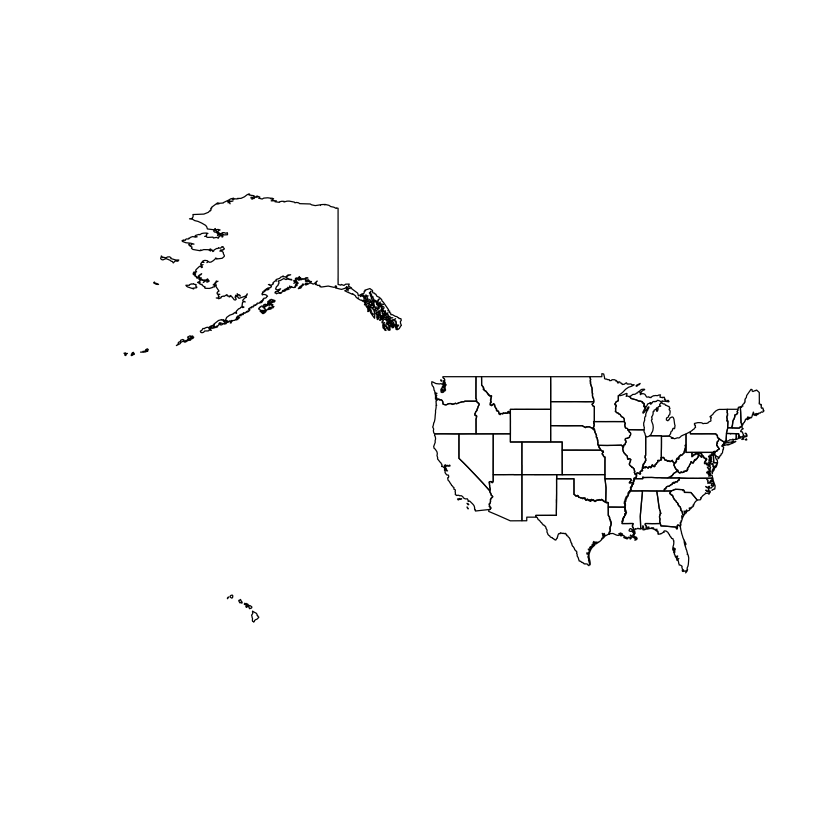

In [9]:
earthquakes <- read.csv("earthquakes.csv")
usa <- readOGR("states_21basic")

glimpse(earthquakes)
plot(usa)

We can see from this that earthquakes.csv provides us with a wealth of information including Latitude and Longitude and that the USA shapefile appears as expected, except for possibly being projected using an unfamiliar coordinate reference system. 

## Make our Data Spatial
First we want to reproject our USA shapefile to EPSG 4326, and then we want to use the "sp" package to make our earthquake data spatial using the included Lat/Long information. With that done, we are able to visualize our data! 

Warning message:
“package ‘sf’ was built under R version 3.4.4”Linking to GEOS 3.6.1, GDAL 2.1.3, PROJ 4.9.3


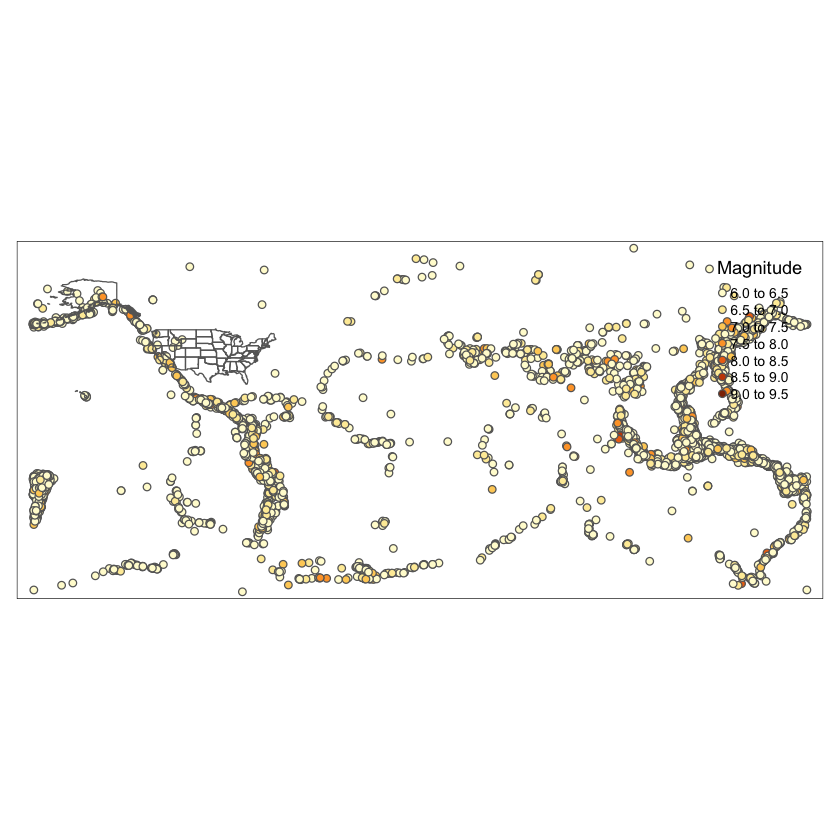

In [10]:
new.crs <- CRS("+init=epsg:4326")
usa <- spTransform(usa, new.crs)

coordinates(earthquakes) <- earthquakes[,c("Longitude", "Latitude")]
proj4string(earthquakes) <- new.crs

tm_shape(earthquakes) +
  tm_bubbles(size = 0.1, col = "Magnitude") +
  tm_shape(usa) +
  tm_borders()

Admittedly, not the best plot, but it's a good start! Also, we can see that our data appears as expected. The USA shapefile is in the right part of the map and the ring of fire is clearly visible in the plotted earthquake data. 

## Improving our Preliminary Visualization
By simply cropping our earthquake data, we can make our visualization substantially neater and more useful. If you are using R Studio, then try changing tmap_mode from "plot" to "view" (Jupyter Notebook causes issues with this) 

tmap mode set to plotting


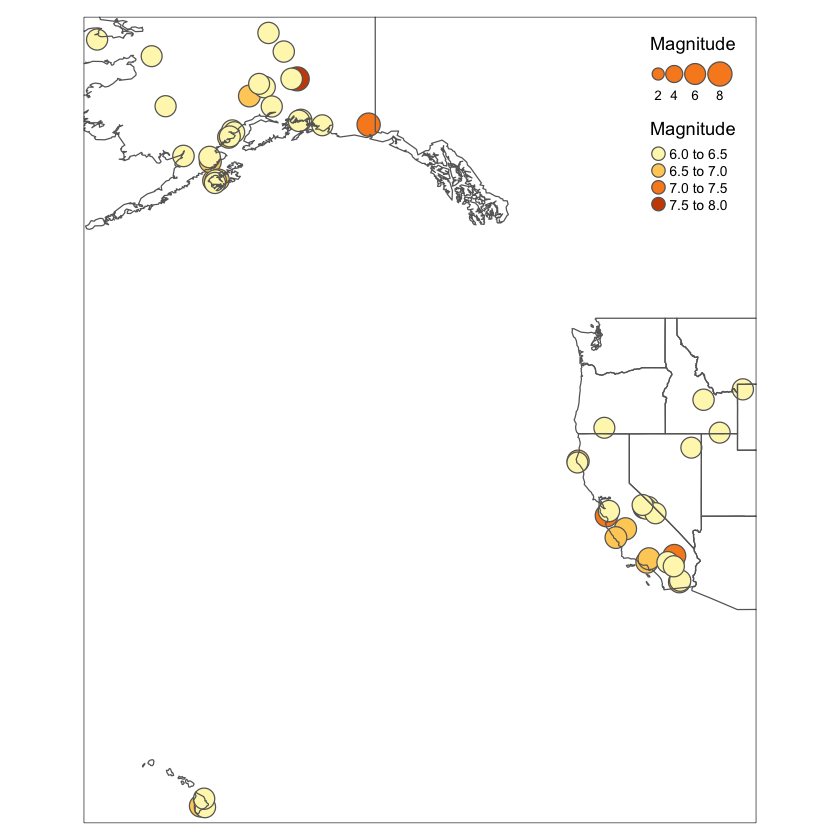

In [16]:
usa.quakes <- earthquakes[usa,]

tmap_mode("plot")

tm_shape(usa.quakes) +
  tm_bubbles(size = "Magnitude", col = "Magnitude") +
  tm_shape(usa) +
  tm_borders()

## Extract State Names From Data
Now that we can see our data, let's find out what state each earthquake occurred in so that we can find out the states that most commonly see major earthquakes. 

In [18]:
usa.overlay <- over(usa.quakes, usa)

usa$STATE_NAME <- as.character(usa$STATE_NAME)

usa.quakes@data$State <- as.character(usa.overlay$STATE_NAME)

quake.num <- usa.quakes@data %>%
  group_by(State) %>%
  summarise(total = n())

names(quake.num) <- c("STATE_NAME", "QUAKE_NUM")

quake.num

STATE_NAME,QUAKE_NUM
Alaska,26
California,21
Hawaii,3
Idaho,2
Nevada,1
Oregon,1
Wyoming,1


As we can see, major quakes appear to be restricted to a handful of western states. Let's attach this data back to the USA shapefile so we can make a final visualization

In [20]:
usa.quakes.state <- usa

usa.quakes.state@data <- left_join(usa@data, quake.num, by = "STATE_NAME")

usa.quakes.state$QUAKE_NUM[which(is.na(usa.quakes.state$QUAKE_NUM))] <- 0

## Visualize our Final Product

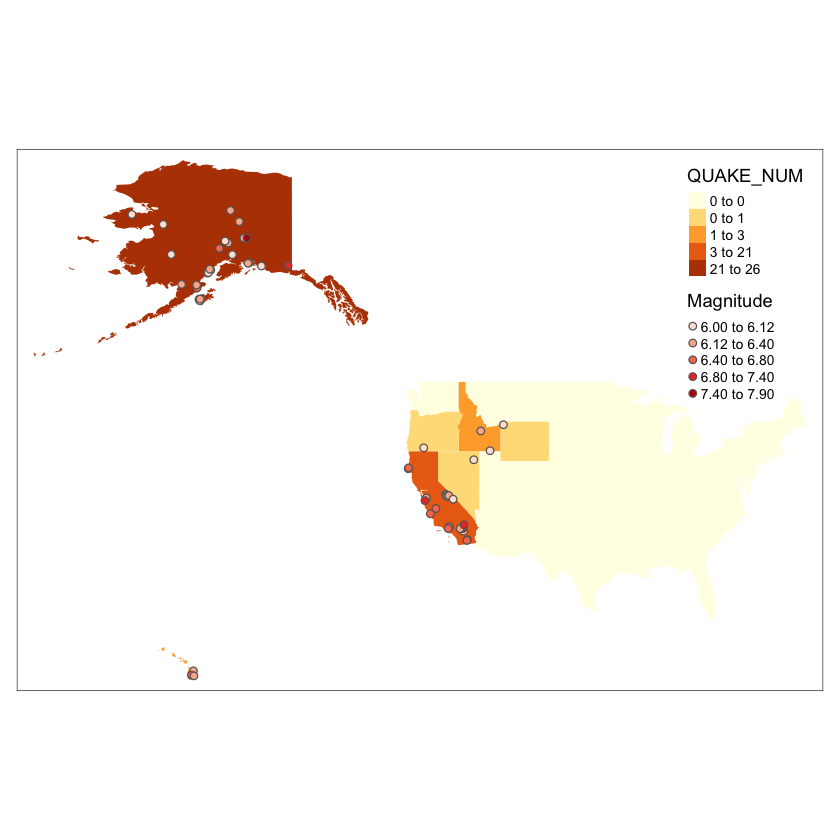

In [21]:
tm_shape(usa.quakes.state) +
  tm_fill(col = "QUAKE_NUM", style = "jenks") +
  tm_shape(usa.quakes) +
  tm_bubbles(size = 0.1, col = "Magnitude", style = "jenks", pal = "Reds") 

Once again, this visualzation could be made interactive in your R environment using the instructions above. It shows us that the vast majority of the USA saw 0 major quakes in the examined time period and that of the ones that did experience major quakes, Alaska and California saw by far the largest number of them. 